In [1]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import copy
import math


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns
import matplotlib.dates as mdates



import warnings
warnings.filterwarnings("ignore") # In order not to show the warnings in the notebook


# Introduction
Time series forecasting has been dominated by linear
methods because they are well understood and effective on
many simpler forecasting problems. However, by using
deep learning we are able to automatically learn arbitrary
complex mappings from inputs to outputs. The bitcoin
price prediction that has been worked on in this project is a
regression problem, where the prediction model predicts the
next Bitcoin price based on the previous. We studied, implemented and compared various Machine Learning and deep
learning methods, such as, prophet, Convolutional Neural
Network (CNN) and long short-term memory (LSTM).

## Data Used

The dataset in the project is imported by Python using
Yahoo APIs and contains the USD bitcoin price of each day
from 2014 to 2021 and it includes six features: Open indicates the price at the beginning of the day, Close indicates
the price at the end of the day, Adjusted Close, Volume of
the sale, High price of the day and Low price of the day.

## 1. Data Preprocessing

### a. Importing and Analysing the Data

In [2]:
# Importing data 
Bitcoin_data = pd.read_csv('data.csv', parse_dates=['Date'], sep=',', index_col='Date')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
Bitcoin_data.head(5)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0,457.334015
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0,424.440002
2014-09-18,424.102997,427.834992,384.532013,394.795990,37919700.0,394.795990
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0,408.903992
2014-09-20,408.084992,412.425995,393.181000,398.821014,26580100.0,398.821014


In [3]:
# checking for nulls
Bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2014-09-16 to 2021-10-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2586 non-null   float64
 1   High       2586 non-null   float64
 2   Low        2586 non-null   float64
 3   Adj Close  2586 non-null   float64
 4   Volume     2586 non-null   float64
 5   Close      2586 non-null   float64
dtypes: float64(6)
memory usage: 141.4 KB


The
dataset has been examined for null values and it didn’t have any missing values.

In [4]:
# checking if close is not equal to adj close
Bitcoin_data[Bitcoin_data['Close']!=Bitcoin_data['Adj Close']]

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,


The ‘Close’ and ‘Adj Close’
columns are identical because Cryptocurrency prices differ
from traditional stock prices. So ‘Close’ price is chosen as
the target variable.

In [5]:
# checking the main parameters
Bitcoin_data.describe()

,Open,High,Low,Adj Close,Volume,Close
count,2586.000000,2586.000000,2586.000000,2586.000000,2.586000e+03,2586.000000
mean,9460.479761,9729.703537,9173.223236,9483.798763,1.375499e+10,9483.798763
std,13881.464139,14299.916556,13424.115329,13919.027751,1.989196e+10,13919.027751
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,178.102997
25%,577.754990,582.823242,573.438751,577.567490,7.406615e+07,577.567490
50%,5515.076172,5647.827149,5353.012940,5540.485108,4.568140e+09,5540.485108
75%,9699.704834,9908.871582,9507.834717,9700.673340,2.224211e+10,9700.673340
max,63523.753910,64863.097660,62208.964840,63503.457030,3.510000e+11,63503.457030


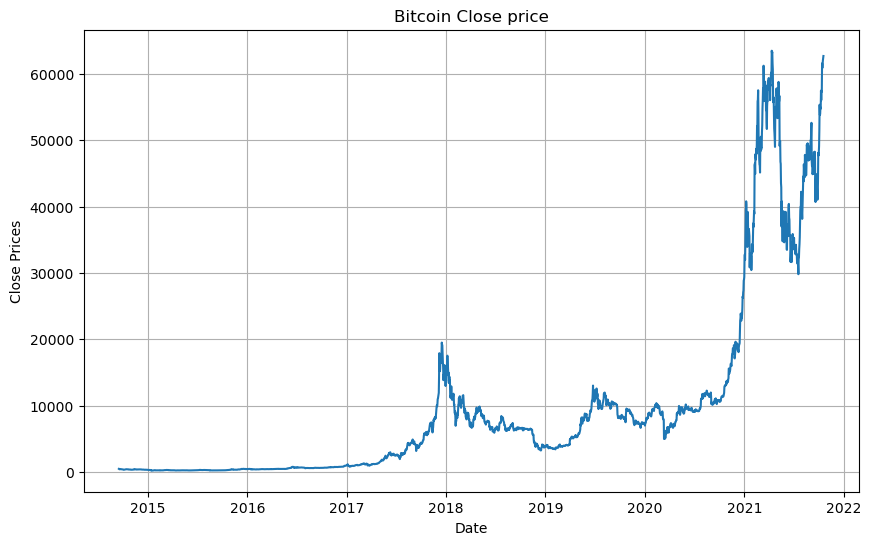

In [6]:
# Plot closing prices
df_close = Bitcoin_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Bitcoin Close price');

### b. Checking Stationarity

In [7]:
  def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

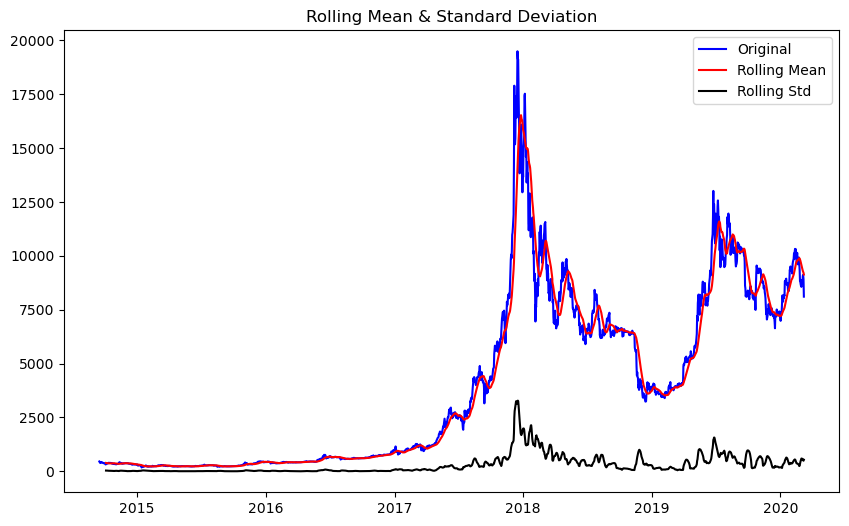

Results of Dickey-Fuller Test:
Test Statistic                   -1.744147
p-value                           0.408522
#Lags Used                       21.000000
Number of Observations Used    1978.000000
Critical Value (1%)              -3.433660
Critical Value (5%)              -2.863002
Critical Value (10%)             -2.567548
dtype: float64


In [8]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

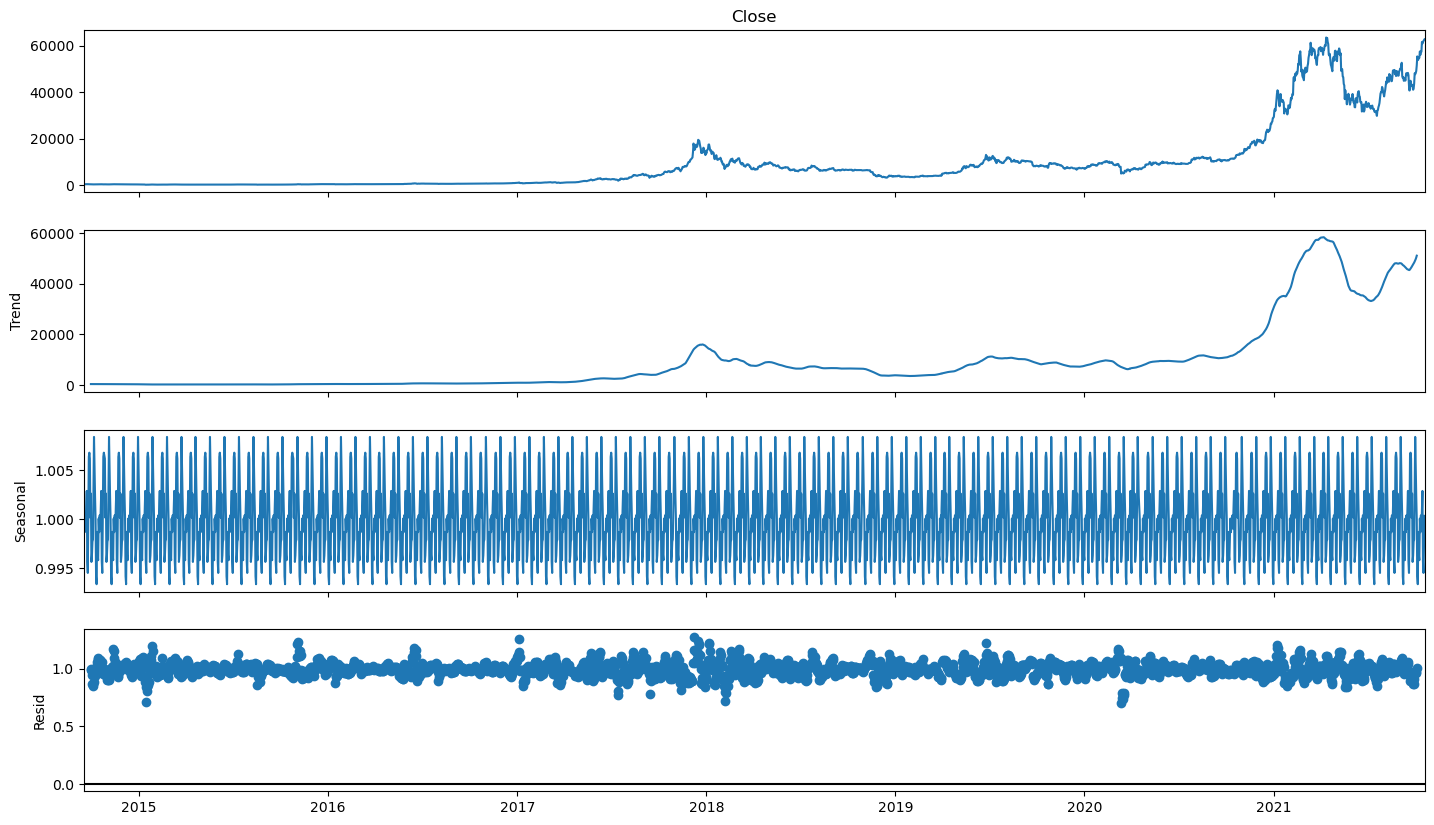

In [9]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a month
# The result below is just to have a first visualization of trend andseasonality. Here we take a monthly average but to forecast a bitcoin 
# price, it is more difficult than that to choose the right number of days to average on
result = seasonal_decompose(df_close, model='multiplicative', period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

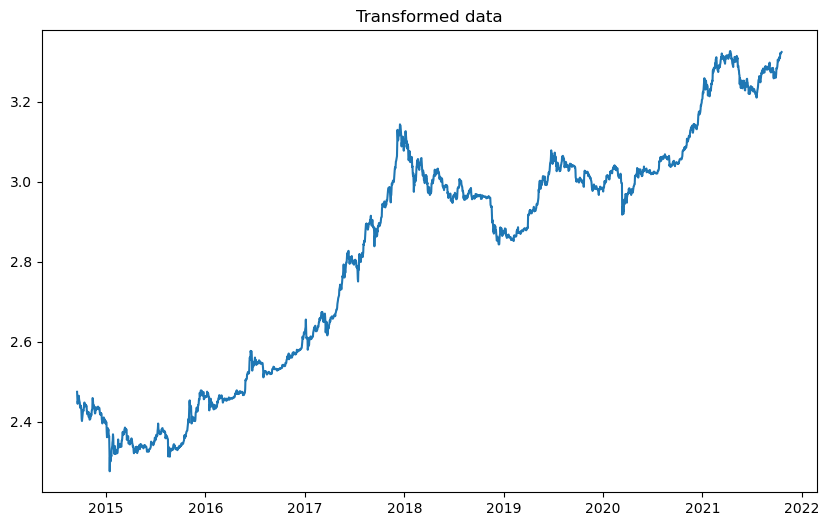

In [10]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data');

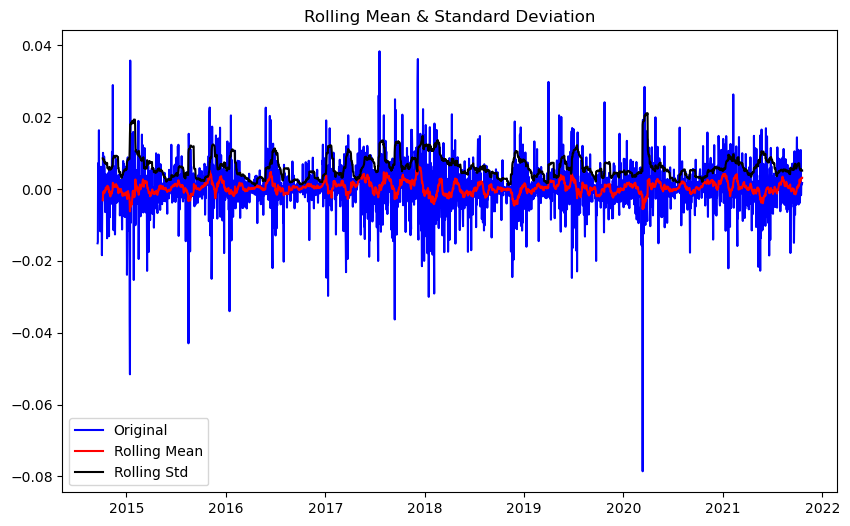

Results of Dickey-Fuller Test:
Test Statistic                -1.548004e+01
p-value                        2.563303e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.575000e+03
Critical Value (1%)           -3.432892e+00
Critical Value (5%)           -2.862663e+00
Critical Value (10%)          -2.567368e+00
dtype: float64


In [11]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

# CNN

In [12]:

# Scaling
bd = df_close_shift.values
cnn_dataset = bd.reshape(len(bd), 1)


In [13]:
class CNN(torch.nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, hidden_dim, output_size):
        super(CNN, self).__init__()

        self.main = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(hidden_dim, 10),
            torch.nn.Linear(10, output_size)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [14]:
def split_sequence(sequence, n_steps):
    """
    Given the data set and n_steps as the window size
    returns two Numpy array X and y separetd based on the n_step
    """
    X, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [15]:
def data_loader(x, y, train_split, test_split, batch_size):
    """Prepare data by applying sliding windows and return data loader"""

    # Split to Train, Validation and Test Set #
    train_seq, test_seq, train_label, test_label = train_test_split(x, y, train_size=train_split, shuffle=False)
    val_seq, test_seq, val_label, test_label = train_test_split(test_seq, test_label, train_size=test_split, shuffle=False)
    
    # Convert to Tensor #
    train_set = TensorDataset(torch.from_numpy(train_seq.astype(np.float32)), torch.from_numpy(train_label.astype(np.float32)))
    val_set = TensorDataset(torch.from_numpy(val_seq.astype(np.float32)), torch.from_numpy(val_label.astype(np.float32)))
    test_set = TensorDataset(torch.from_numpy(test_seq.astype(np.float32)), torch.from_numpy(test_label.astype(np.float32)))

    # Data Loader #
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(Bitcoin_data)))
    print('Proportion of valid_set : {:.2f}%'.format(len(val_set)/len(Bitcoin_data)))
    print('Proportion of test_set : {:.2f}%'.format(len(test_set)/len(Bitcoin_data)))

    return train_loader, val_loader, test_loader

In [16]:
cnn_n_steps = 60
batch_size = 128
X, y = split_sequence(cnn_dataset, cnn_n_steps)
train_loader, val_loader, test_loader = data_loader(X, y, 0.6, 0.5, batch_size)

train_losses, val_losses = list(), list()
val_maes, val_mses, val_rmses, val_r2s = list(), list(), list(), list()
test_maes, test_mses, test_rmses, test_r2s = list(), list(), list(), list()
pred_tests, labels = list(), list()

Proportion of train_set : 0.59%
Proportion of valid_set : 0.20%
Proportion of test_set : 0.20%


In [17]:
epochs = 100
cnn_model = CNN(cnn_n_steps, batch_size, 1)
criterion = torch.nn.MSELoss()

# Optimizer 
optim = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

In [18]:
#CNNTrain
for epoch in range(epochs):
    for i, (data, label) in enumerate(train_loader):
            # Forward Data
            pred = cnn_model(data)

            # Calculate Loss
            train_loss = criterion(pred, label)

            # Initialize Optimizer, Back Propagation and Update
            optim.zero_grad()
            train_loss.backward()
            optim.step()

            # Add item to Lists
            train_losses.append(train_loss.item())

            # Print Statistics
    if (epoch+1) % 10 == 0:
            print("Epoch [{}/{}]".format(epoch+1, epochs))
            print("Train Loss {:.4f}".format(np.average(train_losses)))

    # Validation
    with torch.no_grad():
        for i, (data, label) in enumerate(val_loader):
            # Forward Data
            pred_val = cnn_model(data)
            # Calculate Loss
            val_loss = criterion(pred_val, label)

            # Calculate Metrics
            val_mae = mean_absolute_error(label, pred_val)
            val_mse = mean_squared_error(label, pred_val, squared=True)
            val_rmse = mean_squared_error(label, pred_val, squared=False)
            val_r2 = r2_score(label, pred_val)

            # Add item to Lists
            val_losses.append(val_loss.item())
            val_maes.append(val_mae.item())
            val_mses.append(val_mse.item())
            val_rmses.append(val_rmse.item())
            val_r2s.append(val_r2.item())
                
            if (epoch+1) % 10 == 0:
                # Print loss for each 10 epoch
                print("Val Loss {:.4f}".format(np.average(val_losses)))


Epoch [10/100]
Train Loss 0.0058
Val Loss 0.0026
Val Loss 0.0025
Val Loss 0.0024
Val Loss 0.0024
Epoch [20/100]
Train Loss 0.0029
Val Loss 0.0013
Val Loss 0.0012
Val Loss 0.0012
Val Loss 0.0012
Epoch [30/100]
Train Loss 0.0020
Val Loss 0.0008
Val Loss 0.0008
Val Loss 0.0008
Val Loss 0.0008
Epoch [40/100]
Train Loss 0.0015
Val Loss 0.0006
Val Loss 0.0006
Val Loss 0.0006
Val Loss 0.0006
Epoch [50/100]
Train Loss 0.0012
Val Loss 0.0005
Val Loss 0.0005
Val Loss 0.0005
Val Loss 0.0005
Epoch [60/100]
Train Loss 0.0010
Val Loss 0.0004
Val Loss 0.0004
Val Loss 0.0004
Val Loss 0.0004
Epoch [70/100]
Train Loss 0.0009
Val Loss 0.0004
Val Loss 0.0004
Val Loss 0.0004
Val Loss 0.0004
Epoch [80/100]
Train Loss 0.0008
Val Loss 0.0003
Val Loss 0.0003
Val Loss 0.0003
Val Loss 0.0003
Epoch [90/100]
Train Loss 0.0007
Val Loss 0.0003
Val Loss 0.0003
Val Loss 0.0003
Val Loss 0.0003
Epoch [100/100]
Train Loss 0.0006
Val Loss 0.0003
Val Loss 0.0003
Val Loss 0.0003
Val Loss 0.0003


In [19]:
#CNN Test
with torch.no_grad():
    for i, (data, label) in enumerate(test_loader):
        pred_test = cnn_model(data)
        pred_tests += pred_test.tolist()
        labels += label.tolist()

In [20]:
    test_days = len(pred_tests)
    test_original = df_close.iloc[-test_days:]
    pred_array = np.array(pred_tests)
    pred_data = pd.DataFrame(pred_array[:,0], test_original.index,columns=['Close'])
    pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:] 
    pred_data = pred_data.apply(np.square)
    pred_data = pred_data.apply(np.exp)
    
    label_array = np.array(labels)
    true_data = pd.DataFrame(label_array[:,0], test_original.index,columns=['Close'])
    true_data['Close'] = true_data['Close'] + df_close_tf.shift().values[-test_days:] 
    true_data = true_data.apply(np.square)
    true_data = true_data.apply(np.exp)

In [21]:
    test_mae = mean_absolute_error(true_data, pred_data)
    test_mse = mean_squared_error(true_data, pred_data, squared=True)
    test_rmse = mean_squared_error(true_data, pred_data, squared=False)
    test_r2 = r2_score(true_data, pred_data)

    # Add item to Lists
    test_maes.append(test_mae.item())
    test_mses.append(test_mse.item())
    test_rmses.append(test_rmse.item())
    test_r2s.append(test_r2.item())
        
    # Print Statistics
    print("\n****---- Test Metrics ----****")
    print(" MAE : {:.4f}".format(np.average(test_maes)))
    print("RMSE : {:.4f}".format(np.average(test_rmses)))


****---- Test Metrics ----****
 MAE : 982.3504
RMSE : 1516.1205
